# 1. Описание данных
Имеется набор изображений еды 4-х видов:
* 1724 изображения хлеба в подкаталоге Bread
* 1500 изображений десертов в подкаталоге Dessert
* 1757 изображений мяса в подкаталоге Meat
* 1500 изображений супов подкаталоге Soup

# 2. Подход к решению задачи
Для классификации изображений будем использовать последовательную модель Sequential. Используя ее, создадим сверточную нейросеть. Разрабатываемая сеть будет выполнять свои уровни последовательно, т.е. будет сетью прямого
распространения. Наша нейронная сеть будет иметь несколько сверточныхслоев. В соответствии с концепцией СНС для укрепления масштаба полученных признаков применем метод объединения – max pooling. При применении max-pooling фильтр выбирает максимум из пикселей, покрытых фильтром.Фильтр действует как окно, из которого выбирается только максимальное значение для вывода. Для повышения производительности и стабилизации работы НС будем использовать Batch-normalization. После добавим два полносвязных слоя, чтобы добиться нужной размерности, соответствующей количеству классов.

Тогда сеть имеет вид:

    𝐼𝑁 𝑃 𝑈 𝑇 ⇒ 𝐶𝑂𝑁 𝑉 32 ⇒ 𝑅𝐸𝐿𝑈 ⇒ 𝐵𝑁 ⇒ 𝑃 𝑂𝑂𝐿 ⇒
    ⇒ [𝐶𝑂𝑁 𝑉 64 ⇒ 𝑅𝐸𝐿𝑈 ⇒ 𝐵𝑁 ]* 2 ⇒ 𝑃 𝑂𝑂𝐿 ⇒
    ⇒ [𝐶𝑂𝑁 𝑉 128 ⇒ 𝑅𝐸𝐿𝑈 ⇒ 𝐵𝑁 ]* 3 ⇒ 𝑃 𝑂𝑂𝐿 ⇒
    ⇒ 𝐹 𝐶512 ⇒ 𝑅𝐸𝐿𝑈 ⇒ 𝐹 𝐶3 ⇒ 𝑆𝑂𝐹 𝑇 𝑀 𝐴𝑋
Также для получения лучших результатов обобщения модели используем
аугментацию данных – методика создания дополнительных данных из име-
ющихся.

# 3. Реализация

### 3.1 Подключение модулей

In [1]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Add, ReLU
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

2022-12-13 06:45:21.544023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 06:45:21.659196: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/eshevlyakov/.pyenv/versions/3.10.7/envs/study/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-13 06:45:21.659215: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 06:45:22.447795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic 

### 3.2 Объявление нужных классов и функций

In [2]:
class Preprocessor:
    """
    Предобработчик изображений
    """
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        return cv2.resize(image, (self.width, self.height), interpolation = self.inter)


class DatasetLoader:
    """
    Загрузчик изображений
    """
    def __init__(self, preprocessors=[]):
        self.preprocessors = preprocessors
        
    def load(self, image_Paths):
        data, labels = [], []

        for imagePath in image_Paths:
            image = cv2.imread(imagePath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            label = imagePath.split (os.path.sep)[-2]

            for p in self.preprocessors:
                image = p.preprocess(image)

            data.append(image)
            labels.append(label)

        return(np.array(data), np.array(labels))


class ConvNetComBNDO:
    """
    Конфигуратор нейросети
    """
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding="same", input_shape=inputShape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding="same"))
        model.add(BatchNormalization())
        model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding="same"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding="same") )
        model.add(BatchNormalization())
        model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding="same"))
        model.add(BatchNormalization())
        model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding="same"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(512, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(classes, activation = 'softmax'))
        return model


def visual(X_train, Y_train):
    """
    Визуализация данных
    """
    index = np.random.choice(np.arange(len(X_train)), 24, replace=False)
    figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16,9))

    for item in zip(axes.ravel(), X_train[index], Y_train[index]):
        axes, image, target = item
        axes.imshow(image)
        axes.set_xticks([])
        axes.set_yticks([])
        axes.set_title(target)
    plt.show()


def incorrect(X_test,Y_test, pred):
    """
    Вывод неправильных прогнозов
    """
    food = ('Bread','Dessert','Meat', 'Soup')
    incorrect_predictions = []
    for i, (p, e) in enumerate(zip(pred,Y_test)):
        predicted, expected = np.argmax(p), np.argmax(e)
        if predicted != expected:
            incorrect_predictions.append((i, X_test[i], predicted, expected))
    
    figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16,12))

    for item in zip(axes.ravel(), incorrect_predictions):
        axes, inc_pred = item
        axes.imshow(inc_pred[1])
        axes.set_xticks([])
        axes.set_yticks([])
        axes.set_title(f'p: {food[inc_pred[2]]}; e: {food[inc_pred[3]]}')
        
    plt.show()
    confusion = tf.math.confusion_matrix(Y_test.argmax(axis=1), pred.argmax(axis=1))
    print(confusion)


def visual_incorrect(Epochs, Hist):
    """
    Отображение результатов
    """
    N = np.arange(0, Epochs)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, Hist.history["loss"], label="train_loss")
    plt.plot(N, Hist.history["val_loss"], label="val_loss")
    plt.plot(N, Hist.history["accuracy"], label="train_acc")
    plt.plot(N, Hist.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

### 3.3 Подготовка данных

In [3]:
imagePaths = list(paths.list_images('data/food'))
random.seed(42)
random.shuffle(imagePaths)

Preprocessor и DatasetLoader

In [4]:
input_width = 64
sp = Preprocessor(input_width, input_width)
dsl = DatasetLoader(preprocessors=[sp])

(data, labels) = dsl.load(imagePaths)
data = data.astype('float32') / 255

Разделение выборки и обработка меток

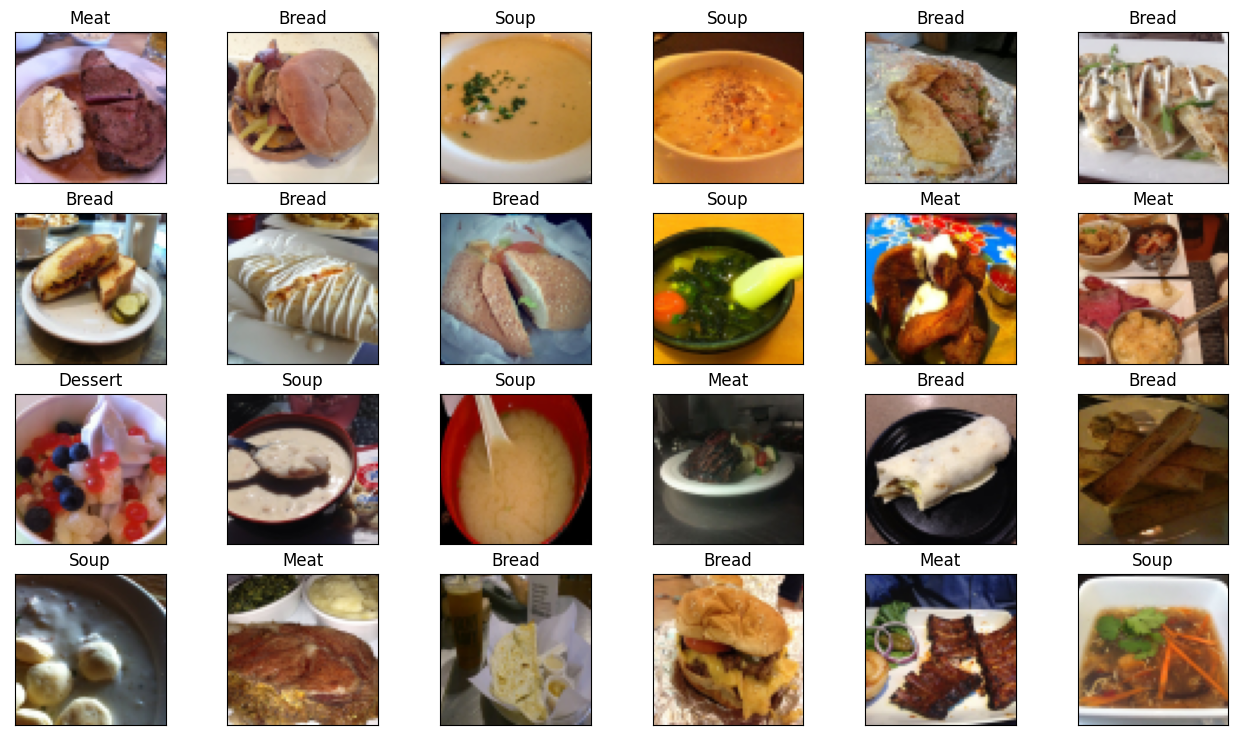

In [5]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)
visual(trainX, trainY)

lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

### 3.4 Создание модели

In [6]:
model = ConvNetComBNDO.build(input_width, input_width, 3, 4)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

2022-12-13 06:45:48.179903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 06:45:48.180144: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/eshevlyakov/.pyenv/versions/3.10.7/envs/study/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-13 06:45:48.180233: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/eshevlyakov/.pyenv/versions/3.10.7/envs/study/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-13 06:45:48.180299: W tensorflow/compiler/xla

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       2

In [7]:
EPOCHS = 80
H = model.fit(aug.flow(trainX, trainY), epochs=EPOCHS, validation_data=(testX, testY))

Epoch 1/80
152/152 [==============================] - ETA: 0s - loss: 1.6839 - accuracy: 0.4130

2022-12-13 06:46:44.751651: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 79675392 exceeds 10% of free system memory.


152/152 [==============================] - 59s 373ms/step - loss: 1.6839 - accuracy: 0.4130 - val_loss: 2.7502 - val_accuracy: 0.2215
Epoch 2/80
152/152 [==============================] - 52s 344ms/step - loss: 1.4573 - accuracy: 0.4568 - val_loss: 1.9231 - val_accuracy: 0.3159
Epoch 3/80
152/152 [==============================] - 52s 343ms/step - loss: 1.2392 - accuracy: 0.5243 - val_loss: 1.2855 - val_accuracy: 0.4985
Epoch 4/80
152/152 [==============================] - 54s 352ms/step - loss: 1.1373 - accuracy: 0.5537 - val_loss: 1.1153 - val_accuracy: 0.5472
Epoch 5/80
152/152 [==============================] - 55s 363ms/step - loss: 1.0740 - accuracy: 0.5728 - val_loss: 1.3545 - val_accuracy: 0.5089
Epoch 6/80
152/152 [==============================] - 56s 367ms/step - loss: 0.9963 - accuracy: 0.6095 - val_loss: 1.0057 - val_accuracy: 0.5941
Epoch 7/80
152/152 [==============================] - 52s 344ms/step - loss: 0.9570 - accuracy: 0.6169 - val_loss: 1.3184 - val_accuracy: 0.5

### 3.5 Анализ результатов

2022-12-13 07:50:22.746907: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 79675392 exceeds 10% of free system memory.


51/51 [==============================] - 2s 45ms/step
0: 0.0000043641%
1: 0.0029009783%
2: 0.0000058882%
3: 99.9970853329%


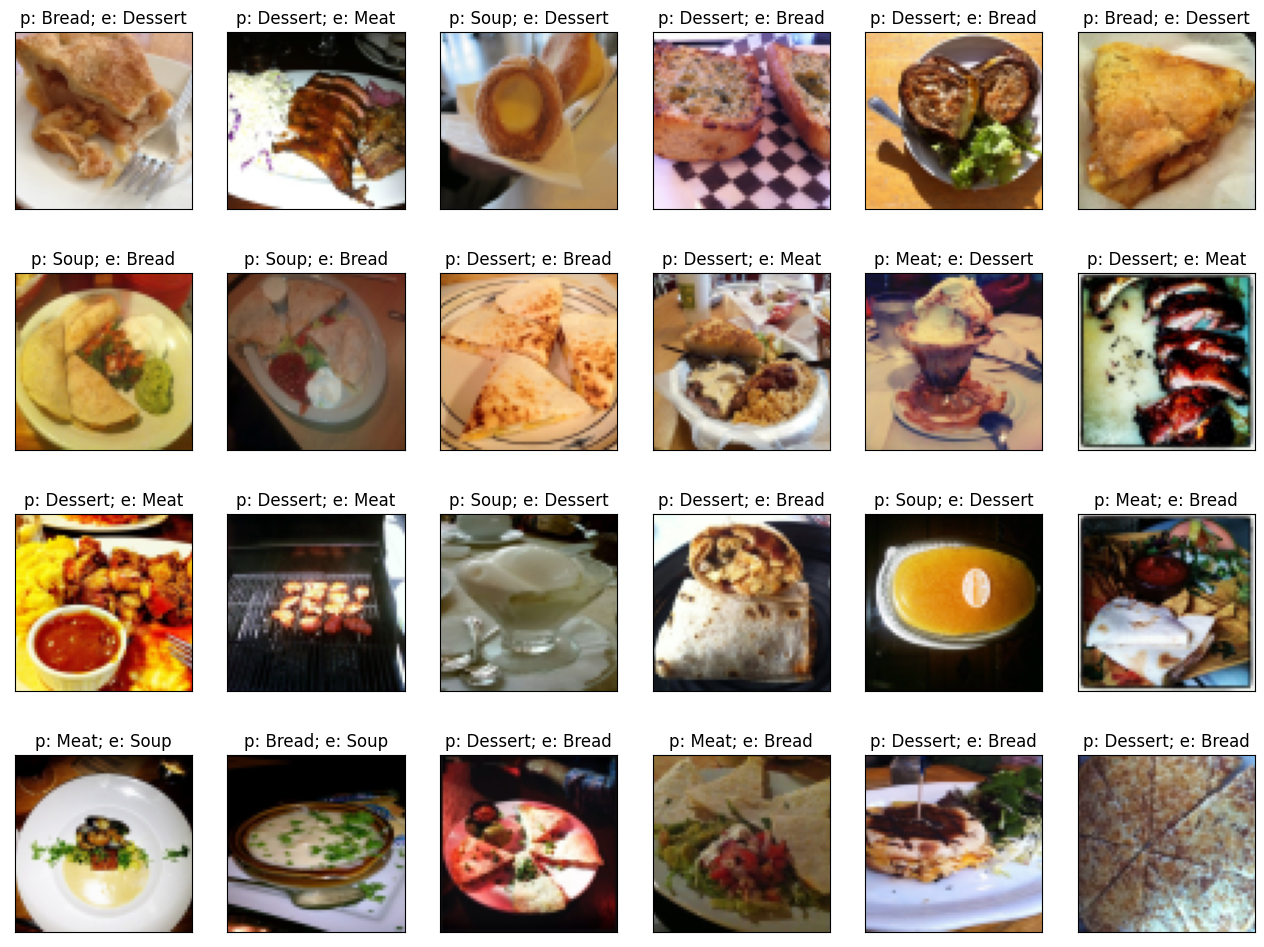

tf.Tensor(
[[258 123  29  19]
 [ 23 345  18  29]
 [ 21 118 268  13]
 [  9  40   3 305]], shape=(4, 4), dtype=int32)


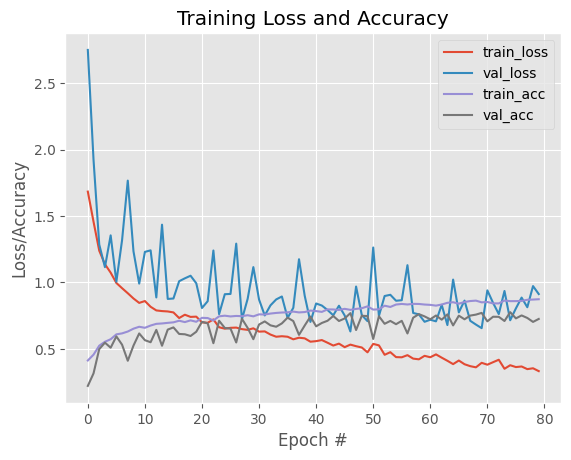

In [8]:
predictions = model.predict(testX)

for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')

incorrect(testX, testY, predictions)

visual_incorrect(EPOCHS, H)